In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa 

C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_classes = 10
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
print("X_train shape" , x_train.shape)
print("X_test shape" , y_train.shape)
print("Y_train shape" , x_test.shape)
print("Y_test shape" , y_test.shape)

X_train shape (50000, 32, 32, 3)
X_test shape (50000, 1)
Y_train shape (10000, 32, 32, 3)
Y_test shape (10000, 1)


In [4]:
#x_train = x_train[:500]
#y_train = y_train[:500]
#x_test = x_test[:500]
#y_test = y_test[:500]

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
patch_size = 6
image_size = 72
num_patches = (image_size // patch_size)**2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim*2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor =0.02),
        layers.RandomZoom(height_factor = 0.2, width_factor =0.2)
    ],
    name = 'data_augmentation'
)
data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size 72 x 72
Patch size 6 x 6
Patches per image: 144
Elements per patch: 108


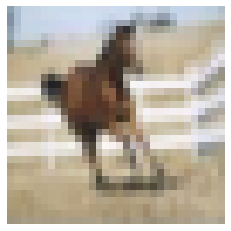

In [9]:
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size = (image_size, image_size))
patches = Patches(patch_size)(resized_image)
print("Image size", image_size,'x', image_size)
print("Patch size", patch_size,'x', patch_size)
print("Patches per image:", patches.shape[1])
print("Elements per patch:", patches.shape[-1])

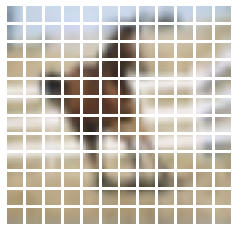

In [10]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x2, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [13]:
def run(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy")], )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy',
                                                          save_best_only=True, save_weights_only=True)

    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1,
                        callbacks=[checkpoint_callback])

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print("Accuracy:", accuracy)
    print("Top 5 Accuracy:", top_5_accuracy)

In [14]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)


Epoch 1/30
176/176 [==============================] - 876s 5s/step - loss: 2.0456 - accuracy: 0.3128 - top_5_accuracy: 0.8075 - val_loss: 1.5103 - val_accuracy: 0.4622 - val_top_5_accuracy: 0.9126
Epoch 2/30
176/176 [==============================] - 904s 5s/step - loss: 1.5522 - accuracy: 0.4418 - top_5_accuracy: 0.8988 - val_loss: 1.2780 - val_accuracy: 0.5352 - val_top_5_accuracy: 0.9450
Epoch 3/30
176/176 [==============================] - 952s 5s/step - loss: 1.4123 - accuracy: 0.4954 - top_5_accuracy: 0.9236 - val_loss: 1.1806 - val_accuracy: 0.5814 - val_top_5_accuracy: 0.9588
Epoch 4/30
176/176 [==============================] - 852s 5s/step - loss: 1.3047 - accuracy: 0.5359 - top_5_accuracy: 0.9364 - val_loss: 1.0704 - val_accuracy: 0.6178 - val_top_5_accuracy: 0.9632
Epoch 5/30
176/176 [==============================] - 853s 5s/step - loss: 1.2329 - accuracy: 0.5649 - top_5_accuracy: 0.9460 - val_loss: 1.0613 - val_accuracy: 0.6180 - val_top_5_accuracy: 0.9682
Epoch 6/30
176/

In [ ]:
# Save the model architecture to a JSON file
model_architecture_json = vit_classifier.to_json()
with open("vit_classifier_architecture.json", "w") as json_file:
    json_file.write(model_architecture_json)

# Save the model weights to an HDF5 file
vit_classifier.save_weights("vit_classifier_weights.h5")

# Save the model
vit_classifier.save("vit_classifier_model.h5")

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def img_predict(images, model):
    
    if(len(images.shape) == 3):
        images = np.expand_dims(images, axis=0)
    out = model.predict(images)
    prediction = np.argmax(out, axis = 1)
    img_pred = [class_names[i] for i in prediction]
    return img_pred

1/1 [==============================] - 0s 21ms/step


['airplane']

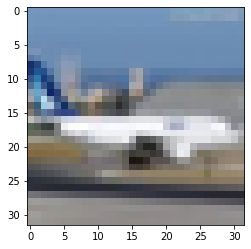

In [18]:
index = 90
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
prediction